In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# Business case

Before diving deep into the code, data inspection and model training, one has to think about the business perspective and requirents first. This is because every project has to be adjusted per industry and per client needs.


### Context

A bank is interested in developing an automated way to predict the risk of loan default. Given historical data from past loans we need to create a model that will seamlessly predict whether a person will default on a loan or not. A default implies huge financial risk for the bank. So on the long run it will save money. However, the algorithm has to be smart enought to know when a person is safe and not assign reject too many potential clients with good credit scores. This might damage the reputation of the bank and turn away future clients.

# Engineering case


The original dataset contains 13444 entries with 14 numerical attributes. Every entry represents a historical client, with one column indicating the outcome if a client defaulted or not - the predictor variable.

In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.

In [2]:
#!wget --no-check-certificate https://pages.stern.nyu.edu/~wgreene/Text/Edition7/TableF7-3.txt 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import seaborn as sns
import plotly.express as ex
%matplotlib inline
import missingno as msno
import plotly.offline as py 
py.init_notebook_mode(connected=True)

from imblearn.over_sampling import BorderlineSMOTE, SMOTE,ADASYN
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Oversample imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification

from sklearn.model_selection import KFold, cross_val_score , train_test_split
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import RobustScaler, PowerTransformer, StandardScaler

from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import  OneHotEncoder

from sklearn.model_selection import KFold, cross_val_score , train_test_split

from sklearn.ensemble import RandomForestClassifier,StackingClassifier
 
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.datasets import make_classification
import imblearn

import optuna
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

In [6]:
df = pd.read_csv("TableF7-3.txt", delimiter=',', na_values=[' ', '  '])

In [7]:
df.shape

(13444, 14)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13444 entries, 0 to 13443
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CARDHLDR   13444 non-null  int64  
 1   DEFAULT    13444 non-null  int64  
 2   AGE        13444 non-null  float64
 3   ACADMOS    13444 non-null  int64  
 4   ADEPCNT    13444 non-null  int64  
 5   MAJORDRG   13444 non-null  int64  
 6   MINORDRG   13444 non-null  int64  
 7   OWNRENT    13444 non-null  int64  
 8   INCOME     13444 non-null  float64
 9   SELFEMPL   13444 non-null  int64  
 10  INCPER     13444 non-null  float64
 11  EXP_INC    13444 non-null  float64
 12  SPENDING   10499 non-null  float64
 13  LOGSPEND   10499 non-null  float64
dtypes: float64(6), int64(8)
memory usage: 1.4 MB


# 1 Dataset exploration

## 1.1 Column explanation

- Cardhldr = Dummy variable, 1 if application for credit card accepted, 0 if not
- Default = 1 if defaulted 0 if not (observed when Cardhldr = 1, 10,499 observations),
- Age = Age in years plus twelfths of a year,
- Adepcnt = 1 + number of dependents,
- Acadmos = months living at current address,
- Majordrg = Number of major derogatory reports,
- Minordrg = Number of minor derogatory reports,
- Ownrent = 1 if owns their home, 0 if rent
- Income = Monthly income (divided by 10,000),
- Selfempl = 1 if self employed, 0 if not,
- Inc_per = Income divided by number of dependents,
- Exp_Inc = Ratio of monthly credit card expenditure to yearly income,
- Spending = Average monthly credit card expenditure (for Cardhldr = 1),
- Logspend = Log of spending. 

- https://pages.stern.nyu.edu/~wgreene/Text/Edition7/2016tablelist7.htm

## 1.1 Exploratory data analysis

In [9]:
df.isna().sum()

CARDHLDR        0
DEFAULT         0
AGE             0
ACADMOS         0
ADEPCNT         0
MAJORDRG        0
MINORDRG        0
OWNRENT         0
INCOME          0
SELFEMPL        0
INCPER          0
EXP_INC         0
SPENDING     2945
LOGSPEND     2945
dtype: int64

Get rid of dummy variable

In [10]:
df = df[df['CARDHLDR'] == 1] # 1 if defaulted 0 if not (observed when Cardhldr = 1, 10,499 observations), 
df = df.drop(['CARDHLDR'], axis=1)

In [11]:
df.DEFAULT.value_counts() 

0    9503
1     996
Name: DEFAULT, dtype: int64

In [12]:
df.DEFAULT.value_counts() / len(df) * 100

0    90.513382
1     9.486618
Name: DEFAULT, dtype: float64

### Data imbalance

Text(0.5, 1.0, 'Data Imbalance')

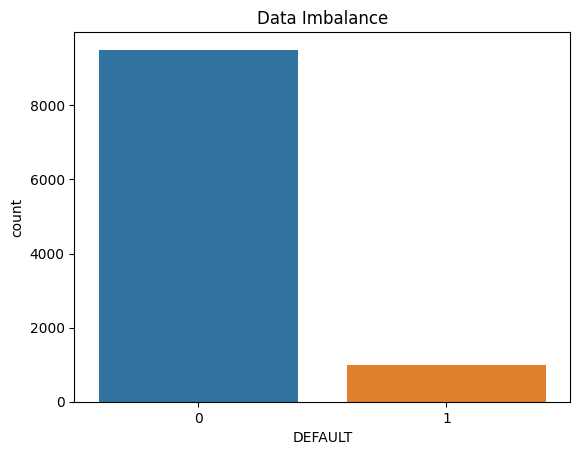

In [13]:
sns.countplot(df, x='DEFAULT')
plt.title("Data Imbalance")

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DEFAULT,10499.0,0.094866,0.293044,0.000000,0.000000,0.000000,0.000000,1.000000
AGE,10499.0,33.674945,10.290998,0.000000,25.750000,31.666666,39.750000,88.666664
ACADMOS,10499.0,55.904181,64.127434,0.000000,12.000000,30.000000,72.000000,564.000000
ADEPCNT,10499.0,0.990380,1.273887,0.000000,0.000000,0.000000,2.000000,9.000000
MAJORDRG,10499.0,0.143252,0.461568,0.000000,0.000000,0.000000,0.000000,6.000000
MINORDRG,10499.0,0.220688,0.637142,0.000000,0.000000,0.000000,0.000000,7.000000
OWNRENT,10499.0,0.479093,0.499587,0.000000,0.000000,0.000000,1.000000,1.000000
INCOME,10499.0,2606.125933,1287.983386,50.000000,1750.000000,2291.666667,3041.666667,8333.250000
SELFEMPL,10499.0,0.053624,0.225285,0.000000,0.000000,0.000000,0.000000,1.000000
INCPER,10499.0,22581.362368,13754.973409,700.000000,12900.000000,20000.000000,28336.666992,150000.000000


In [15]:
df.columns

Index(['DEFAULT', 'AGE', 'ACADMOS', 'ADEPCNT', 'MAJORDRG', 'MINORDRG',
       'OWNRENT', 'INCOME', 'SELFEMPL', 'INCPER', 'EXP_INC', 'SPENDING',
       'LOGSPEND '],
      dtype='object')

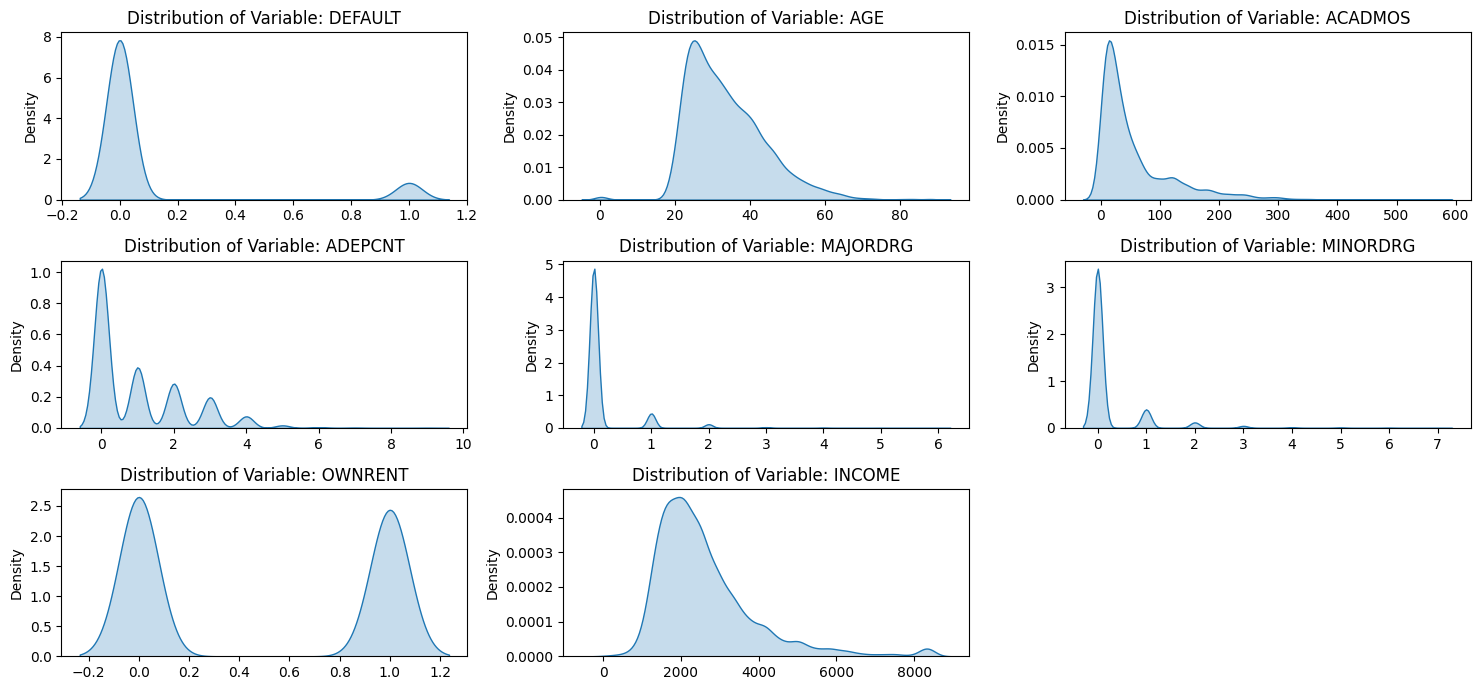

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7), sharex = False, sharey = False)
axes = axes.ravel()  
cols = df.columns[:]

for col, ax in zip(cols, axes):
    sns.kdeplot(data=df, x=col, fill=True, ax=ax)
    ax.set(title=f'Distribution of Variable: {col}', xlabel=None)
    
fig.delaxes(axes[8])
fig.tight_layout()
plt.show()

None of the columns follow a normal data distribution. In the current dataset we luckily don't have any missing values but in a production enviroment it would be best to use median to replace them. In general most of these are left skewed.

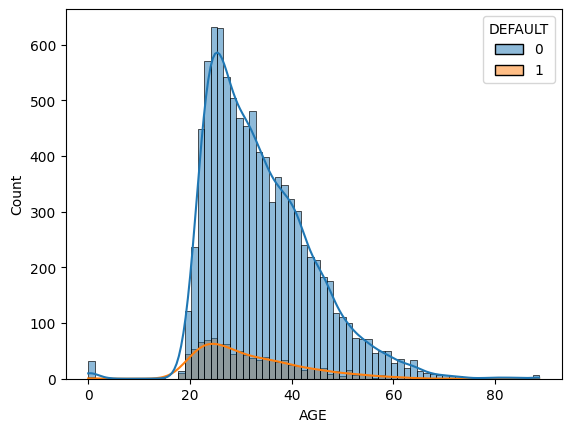

In [17]:
trace1 = sns.histplot(
    data=df, x='AGE', hue='DEFAULT', common_norm=True, kde=True
)

### Correlation

In [18]:
cor = df.corr(method = 'spearman')['DEFAULT'].sort_values(ascending=False)
cor

DEFAULT      1.000000
MINORDRG     0.038994
MAJORDRG     0.022938
ACADMOS      0.003382
ADEPCNT      0.001488
SELFEMPL    -0.010691
EXP_INC     -0.026973
OWNRENT     -0.062578
SPENDING    -0.072348
LOGSPEND    -0.072349
AGE         -0.072573
INCPER      -0.082424
INCOME      -0.135273
Name: DEFAULT, dtype: float64



Correlation between features are target are not very high


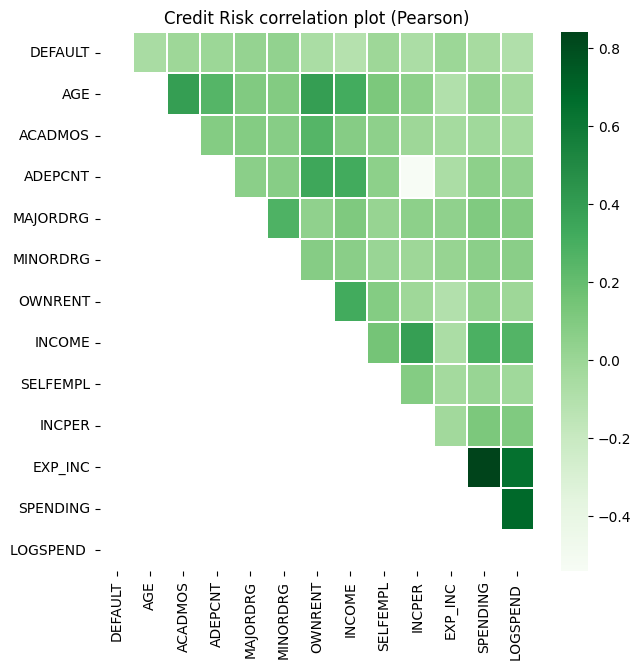

In [19]:
plt.figure(figsize = (7,7))
plt.title('Credit Risk correlation plot (Pearson)')
cor_matrix = df.corr()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
upper_tri
sns.heatmap(upper_tri,xticklabels=cor_matrix.columns,yticklabels=cor_matrix.columns,linewidths=.1,cmap="Greens")
plt.show()


In [20]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
to_drop

['SPENDING', 'LOGSPEND ']

Apart from features derived from each other such as SPENDING and LOGSPEND etc, the correlation between features are target are not very high


In [21]:
cor = df.corr()
cor[((cor >= .5) | (cor<= -.5))]

,DEFAULT,AGE,ACADMOS,ADEPCNT,MAJORDRG,MINORDRG,OWNRENT,INCOME,SELFEMPL,INCPER,EXP_INC,SPENDING,LOGSPEND
DEFAULT,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGE,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACADMOS,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADEPCNT,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,-0.541245,NaN,NaN,NaN
MAJORDRG,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MINORDRG,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OWNRENT,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
INCOME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
SELFEMPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
INCPER,NaN,NaN,NaN,-0.541245,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN


### Checking if Multicollinearity exists in the dataset

In [22]:
#function to check multicolliearity
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = df.select_dtypes(exclude='object').dropna() 
calc_vif(X)

,variables,VIF
0,DEFAULT,1.105403
1,AGE,12.289028
2,ACADMOS,2.140450
3,ADEPCNT,4.439896
4,MAJORDRG,1.214896
5,MINORDRG,1.231996
6,OWNRENT,2.580120
7,INCOME,15.541025
8,SELFEMPL,1.092175
9,INCPER,9.716986


AGE, LOGSPEND, and INCOME have high values for VIF, which indicates that they can be predicted by other independent variables in the dataset.

# Build models
- Catboost
- Random Forest

other models used but not part of this demo: logistic regression, SVM

In [23]:
random_seed = 42
target = 'DEFAULT'
test_size = 0.3 
label_encode = True
catogerical_columns = ['AGE']

median_list = ['ACADMOS'] # not used in the end (no missing values)
mean_list = []
log_list = ['SPENDING', 'INCOME', 'AGE']
TO_DROP = ['LOGSPEND ']#, 'INCPER', 'EXP_INC']

df = df.drop(TO_DROP, axis=1)

- Set random seed to 42
- normalize 'SPENDING', 'INCOME', 'AGE' by log
- drop 'LOGSPEND'

In [24]:
def split_data_for_training(data, target):
    X = data.drop(target, axis=1)
    y = data[target]    
       
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, # deal with data imbalance
                                                        test_size=test_size, random_state=random_seed)
    return X_train, X_test, y_train, y_test


# Train - test split

- Split with a 70/30 ratio into train/val
- use stratify to keep the data imbalance 

In [25]:
X_train, X_test, y_train, y_test = split_data_for_training(df, target)
#X_train.shape, X_test.shape
print("Training samples: ", X_train.shape[0])
print("Test samples: ", X_test.shape[0])

Training samples:  7349
Test samples:  3150


In [26]:
over = imblearn.over_sampling.SMOTE(sampling_strategy='minority')
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority')
steps = [('o', over), ('u', under)]

### Under sampling using Random under sampling

In [27]:
X_train_under, y_train_under = under.fit_resample(X_train, y_train)
print("Training samples: ", X_train_under.shape[0])
print("Test samples (unchanged): ", X_test.shape[0])

Training samples:  1394
Test samples (unchanged):  3150


### Oversampling using SMOTE

In [28]:
X_train_over, y_train_over = over.fit_resample(X_train, y_train)
print("Training samples: ", X_train_over.shape[0])
print("Test samples (unchanged): ", X_test.shape[0])

Training samples:  13304
Test samples (unchanged):  3150


# pipeline

In [29]:
# Imputing nulls and poer transform for numeric columns
num_imputer = SimpleImputer(strategy='median')
power_transformer = PowerTransformer()
 
# Imputing nulls through the encoding for categorical columns
encoder = OneHotEncoder(handle_unknown="ignore")

# Defining different transformers for numeric and categorical columns
num_transformer = make_pipeline(num_imputer)
pow_transformer = make_pipeline(num_transformer ,power_transformer)
cat_transformer = make_pipeline(encoder)
scaler = make_pipeline(RobustScaler(with_centering=False))

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, median_list),
                    ('power',pow_transformer,log_list),
                    ('cat', encoder, catogerical_columns)])

preprocessor = make_pipeline(preprocessor, scaler)
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['ACADMOS']),
                                                 ('power',
                                                  Pipeline(steps=[('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median'))])),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['SPENDING', 'INCOME',
                                                   'AGE']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['AGE'])])),
                ('pipeline',
                 Pipeline(steps=[('robustscaler',
                                  RobustScaler(with_centering=False))]))])

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

def metrics_logger(y_true, y_pred, name='Random Forest'):
    
    print(f"[{name}]")
    print(classification_report(y_true, y_pred, target_names=['No Default', 'Default']))
    print(confusion_matrix(y_true, y_pred))
    print('recall:', recall_score(y_true, y_pred))
    
def feature_importance(pipe, X_test, y_test):
    result = permutation_importance(pipe, X_test, y_test,
                               n_repeats=30,
                               random_state=42)
    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X_test.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances (test set)")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    plt.show()

In [31]:
datasplits = {
'normal': [X_train, y_train],
'under' : [X_train_under, y_train_under],
'over'  : [X_train_over, y_train_over]}


# Model Training
- train 3 versions of each:
- 1. normal split
- 2. under sampling
- 3. oversampling

And validate on unchanged test set (data imbalance proportions of original)

## Catboost

[catboost+normal]
              precision    recall  f1-score   support

  No Default       0.91      1.00      0.95      2851
     Default       0.33      0.01      0.03       299

    accuracy                           0.90      3150
   macro avg       0.62      0.51      0.49      3150
weighted avg       0.85      0.90      0.86      3150

[[2843    8]
 [ 295    4]]
recall: 0.013377926421404682


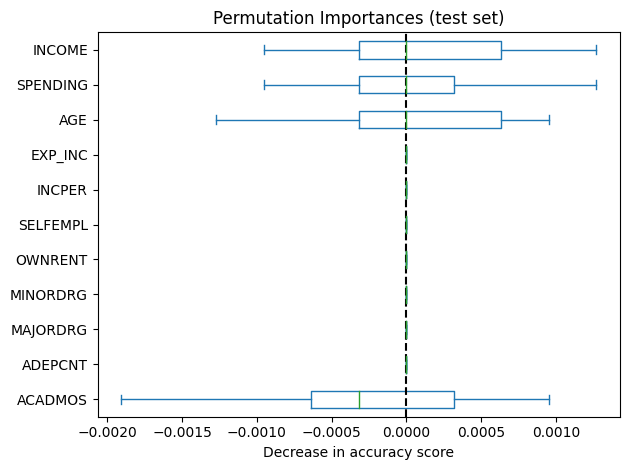

[catboost+under]
              precision    recall  f1-score   support

  No Default       0.93      0.61      0.74      2851
     Default       0.14      0.59      0.22       299

    accuracy                           0.61      3150
   macro avg       0.54      0.60      0.48      3150
weighted avg       0.86      0.61      0.69      3150

[[1737 1114]
 [ 122  177]]
recall: 0.5919732441471572


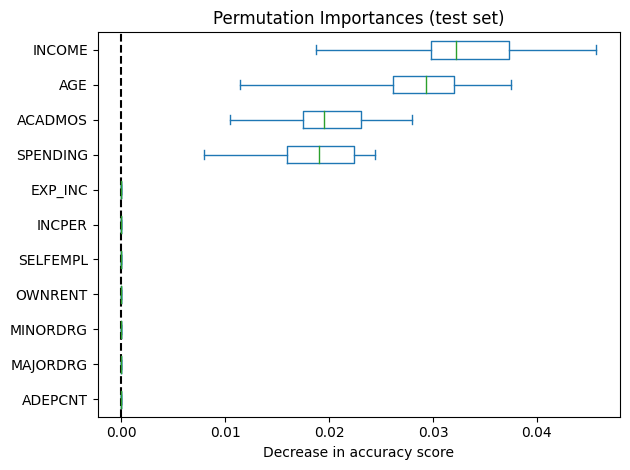

[catboost+over]
              precision    recall  f1-score   support

  No Default       0.91      0.81      0.86      2851
     Default       0.13      0.27      0.18       299

    accuracy                           0.76      3150
   macro avg       0.52      0.54      0.52      3150
weighted avg       0.84      0.76      0.79      3150

[[2316  535]
 [ 219   80]]
recall: 0.26755852842809363


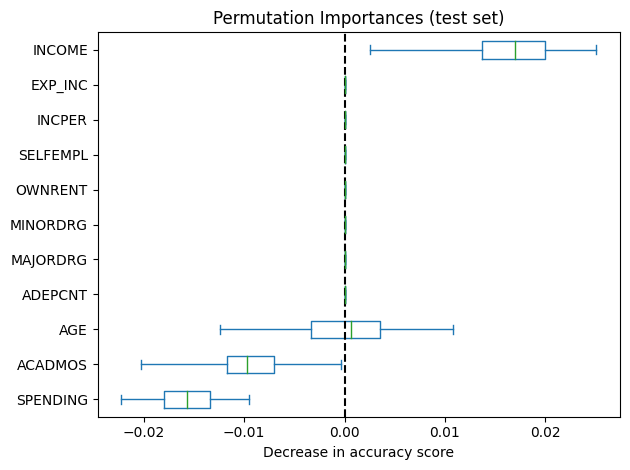

In [32]:
for split_type, (X_train_tmp,y_train_tmp)  in datasplits.items():

    # choosing model
    model_name = cat.CatBoostClassifier(iterations=500, verbose=0,eval_metric="Recall")

    # giving all values to pipeline
    catboost_pipe = make_pipeline(preprocessor, model_name)

    catboost_pipe.fit(X_train_tmp,y_train_tmp)

    y_pred = catboost_pipe.predict(X_test)
    metrics_logger(y_test, y_pred, f'catboost+{split_type}')
    
    feature_importance(catboost_pipe, X_test, y_test)
    


## Random forest



In [33]:
## Random Forest Classifier tuning using Optuna¶
#defining the hyperparatmeter tuning function using optuna
def rf_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 400)
    _max_depth = trial.suggest_int("max_depth", 5, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    #_max_features = trial.suggest_int("max_features", 10, 50)

    clf = RandomForestClassifier(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        #max_features=_max_features,
        n_estimators=_n_estimators,
        n_jobs=-1,
        random_state=random_seed
        )
    clf.fit(X_train_tmp, y_train_tmp)
    return clf.score(X_test, y_test)

### get best params

In [34]:
for split_type, (X_train_tmp,y_train_tmp)  in datasplits.items():
    study = optuna.create_study(direction="maximize")
    study.optimize(rf_objective, n_trials=3)

    #choosing the best parameters
    random_forest_parameters=study.best_params

[I 2023-01-17 19:14:36,566] A new study created in memory with name: no-name-2138fd4c-c772-48bd-a85d-7624eebc5a0e
[I 2023-01-17 19:14:37,084] Trial 0 finished with value: 0.905079365079365 and parameters: {'n_estimators': 398, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.905079365079365.
[I 2023-01-17 19:14:37,708] Trial 1 finished with value: 0.9047619047619048 and parameters: {'n_estimators': 398, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.905079365079365.
[I 2023-01-17 19:14:38,221] Trial 2 finished with value: 0.905079365079365 and parameters: {'n_estimators': 318, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.905079365079365.
[I 2023-01-17 19:14:38,222] A new study created in memory with name: no-name-1d07079e-8e2a-4513-885a-795ab5044ea0
[I 2023-01-17 19:14:38,560] Trial 0 finished with value: 0.6257142857142857 and parameters: {'n_e

[RandomForest+normal]
              precision    recall  f1-score   support

  No Default       0.91      1.00      0.95      2851
     Default       0.00      0.00      0.00       299

    accuracy                           0.91      3150
   macro avg       0.45      0.50      0.48      3150
weighted avg       0.82      0.91      0.86      3150

[[2851    0]
 [ 299    0]]
recall: 0.0


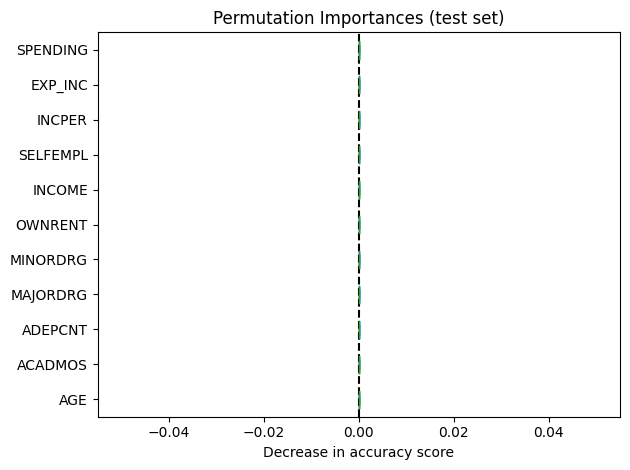

[RandomForest+under]
              precision    recall  f1-score   support

  No Default       0.94      0.59      0.73      2851
     Default       0.14      0.64      0.23       299

    accuracy                           0.60      3150
   macro avg       0.54      0.61      0.48      3150
weighted avg       0.86      0.60      0.68      3150

[[1685 1166]
 [ 109  190]]
recall: 0.6354515050167224


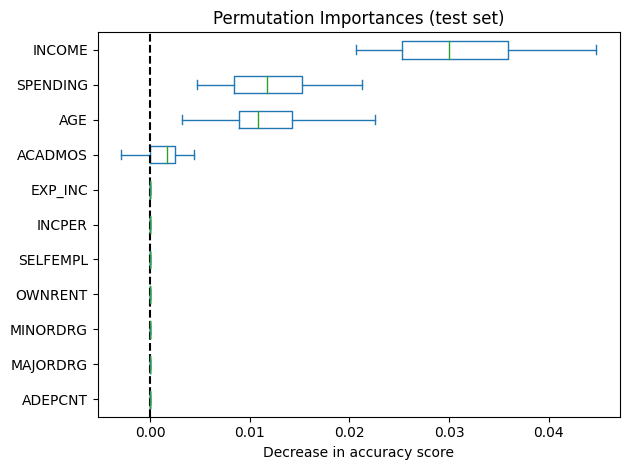

[RandomForest+over]
              precision    recall  f1-score   support

  No Default       0.92      0.68      0.78      2851
     Default       0.12      0.42      0.19       299

    accuracy                           0.66      3150
   macro avg       0.52      0.55      0.48      3150
weighted avg       0.84      0.66      0.73      3150

[[1942  909]
 [ 174  125]]
recall: 0.4180602006688963


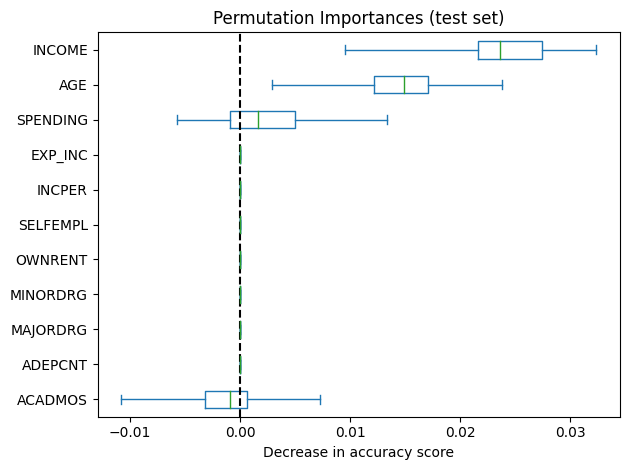

In [35]:
for split_type, (X_train_tmp,y_train_tmp)  in datasplits.items():

    # random forest paraeters tuned using optuna. Code down below
    random_forest_parameters = {'n_estimators': 55, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3}

    # choosing model
    model_name = RandomForestClassifier(n_jobs=-1, random_state=random_seed, **random_forest_parameters)

    # giving all values to pipeline
    rf_pipe = make_pipeline(preprocessor,model_name)

    rf_pipe.fit(X_train_tmp,y_train_tmp)

    y_pred = rf_pipe.predict(X_test)
    metrics_logger(y_test, y_pred, f'RandomForest+{split_type}')
    
    
    feature_importance(rf_pipe, X_test, y_test)

# Present final model

- Random Forest with a recall of 0.64

[RandomForest+over]
              precision    recall  f1-score   support

  No Default       0.94      0.59      0.73      2851
     Default       0.14      0.64      0.23       299

    accuracy                           0.60      3150
   macro avg       0.54      0.61      0.48      3150
weighted avg       0.86      0.60      0.68      3150

[[1685 1166]
 [ 109  190]]
recall: 0.6354515050167224


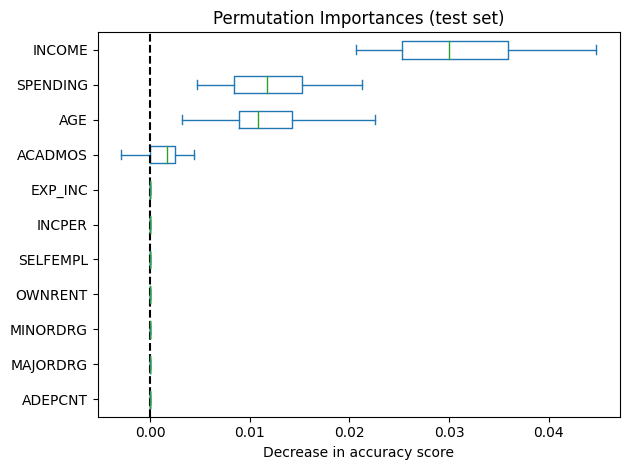

In [36]:

# random forest paraeters tuned using optuna. Code down below
random_forest_parameters = {'n_estimators': 55, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3}

# choosing model
model_name = RandomForestClassifier(n_jobs=-1, random_state=random_seed, **random_forest_parameters)

# giving all values to pipeline
rf_pipe = make_pipeline(preprocessor,model_name)

rf_pipe.fit(*datasplits['under'])

y_pred = rf_pipe.predict(X_test)
metrics_logger(y_test, y_pred, f'RandomForest+{split_type}')


feature_importance(rf_pipe, X_test, y_test)

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [38]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred))#, index=['Safe', 'Default'], columns=['Safe', 'Default'])


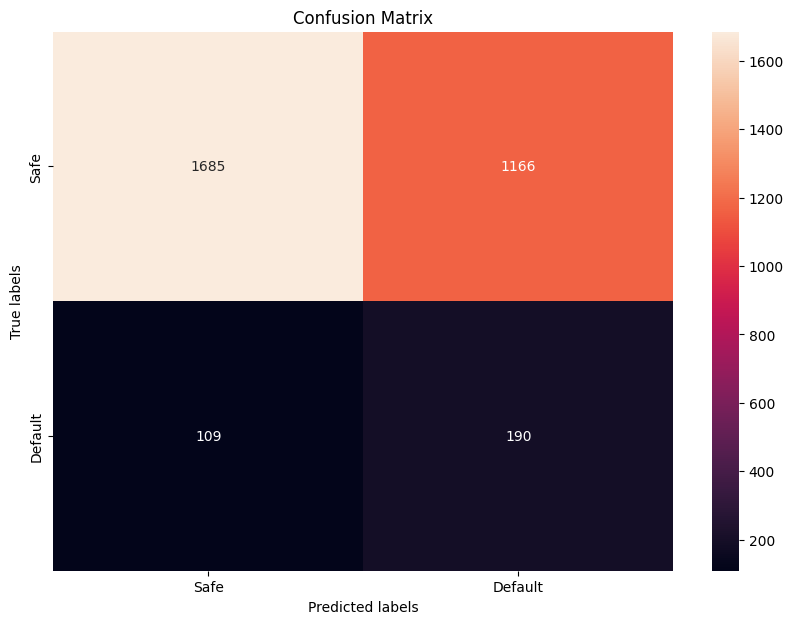

In [39]:
plt.figure(figsize = (10,7))
ax= plt.subplot()
sns.heatmap(df_cm, annot=True, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Safe', 'Default']); ax.yaxis.set_ticklabels(['Safe', 'Default']);

# Future work/what to consider to improve the model

- Try using a brute force approach of hyperparameter search using mutliple models to find the best approach
- Find more data to use
- More feature engineering
- Try a simple fully connected network
- Handle outliers

# Business case summary
- With a recall of over 0.64 we can eliminate the risk of too many False Negatives which is the main priority of the bank. Eliminting the long term risk. However, in order to push this model to production one needs to look for better ways of minimizing the False positives and hence increasing precision. A better metric would be the F1-score which is a harmonic mean between recall and precision